/tmp/ipython-input-4122598338.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(list(tickers.values()), period="2y")["Close"]
[*********************100%***********************]  3 of 3 completed
/tmp/ipython-input-4122598338.py:25: FutureWarning: YF.download() has changed argument auto_adjust default to True
  big_tech = yf.download(["AAPL", "MSFT", "NVDA", "GOOGL", "AMZN", "META"],
[*********************100%***********************]  6 of 6 completed


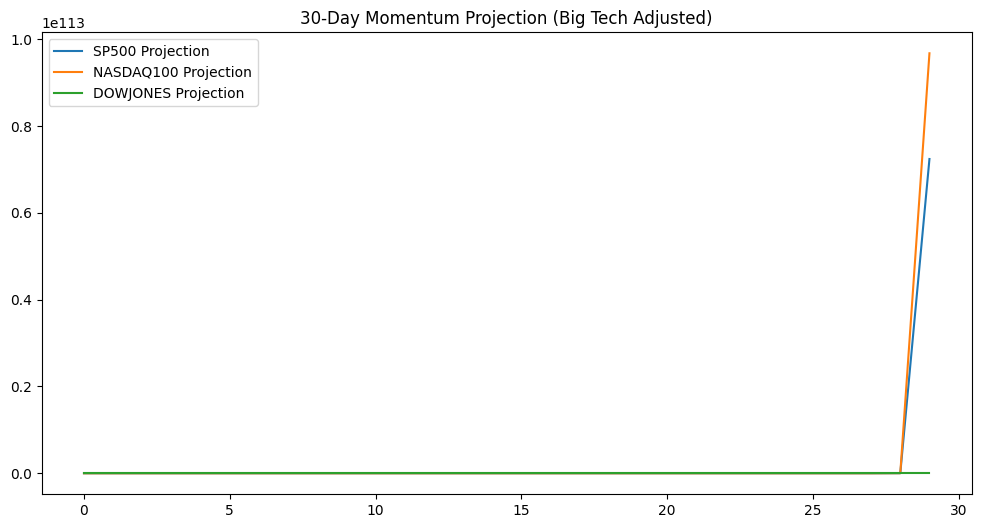

In [ ]:
# ============================================================
# SP500 / Dow / Nasdaq Momentum Projection Engine
# Lauro Beck - Quant Research Model
# ============================================================

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1. Download Market Data
# ------------------------------------------------------------

tickers = {
    "SP500": "^GSPC",
    "NASDAQ100": "^NDX",
    "DOWJONES": "^DJI"
}

data = yf.download(list(tickers.values()), period="2y")["Close"]
data.columns = tickers.keys()

# Big Tech basket (influence proxy)
big_tech = yf.download(["AAPL", "MSFT", "NVDA", "GOOGL", "AMZN", "META"],
                       period="2y")["Close"]

big_tech_index = big_tech.mean(axis=1)

# ------------------------------------------------------------
# 2. Log Returns
# ------------------------------------------------------------

returns = np.log(data / data.shift(1))
bigtech_returns = np.log(big_tech_index / big_tech_index.shift(1))

# ------------------------------------------------------------
# 3. Momentum Signals
# ------------------------------------------------------------

def momentum_signal(series, short=20, mid=50, long=200):
    mom_short = series.pct_change(short)
    mom_mid = series.pct_change(mid)
    mom_long = series.pct_change(long)

    return (mom_short + mom_mid + mom_long) / 3

momentum = data.apply(momentum_signal)

# ------------------------------------------------------------
# 4. Volatility Adjustment
# ------------------------------------------------------------

volatility = returns.rolling(30).std()

vol_adj_momentum = momentum / volatility

# ------------------------------------------------------------
# 5. Big Tech Influence Factor
# ------------------------------------------------------------

bigtech_weight = 0.35  # adjustable structural weight

tech_factor = bigtech_returns.rolling(30).mean()

combined_signal = vol_adj_momentum.copy()

for col in combined_signal.columns:
    if col == "NASDAQ100":
        combined_signal[col] += bigtech_weight * tech_factor
    elif col == "SP500":
        combined_signal[col] += bigtech_weight * 0.6 * tech_factor
    elif col == "DOWJONES":
        combined_signal[col] += bigtech_weight * 0.3 * tech_factor

# ------------------------------------------------------------
# 6. Forward Projection (Drift Model)
# ------------------------------------------------------------

projection_days = 30
last_prices = data.iloc[-1]

drift = combined_signal.iloc[-1]
vol = volatility.iloc[-1]

projections = {}

for index in data.columns:
    mu = drift[index]
    sigma = vol[index]

    simulated = last_prices[index] * np.exp(
        np.cumsum(
            np.random.normal(mu, sigma, projection_days)
        )
    )

    projections[index] = simulated

# ------------------------------------------------------------
# 7. Plot
# ------------------------------------------------------------

plt.figure(figsize=(12,6))

for index in projections:
    plt.plot(projections[index], label=f"{index} Projection")

plt.title("30-Day Momentum Projection (Big Tech Adjusted)")
plt.legend()
plt.show()

In [4]:
!pip install qiskit
import numpy as np
from qiskit import QuantumCircuit

qc = QuantumCircuit(4)

# -----------------------------------
# 1. State Preparation
# -----------------------------------

# Note: trend_strength, tech_strength, vol_stability, and yield_support must be defined
# For example, you might define them based on some market data or other features.
# Example placeholders:
trend_strength = 0.5
tech_strength = 0.7
vol_stability = 0.3
yield_support = 0.6

qc.ry(trend_strength * np.pi, 0)
qc.ry(tech_strength * np.pi, 1)
qc.ry(vol_stability * np.pi, 2)
qc.ry(yield_support * np.pi, 3)

# -----------------------------------
# 2. Macro Causal Structure
# -----------------------------------

qc.cx(3, 0)  # Liquidity → Regime
qc.cx(1, 0)  # Tech → Regime
qc.cx(2, 0)  # Stress → Regime

# -----------------------------------
# 3. Interference Layer
# -----------------------------------

qc.cz(1, 3)  # Tech & Liquidity synergy
qc.cz(2, 3)  # Stress & Liquidity interaction

In [6]:
qc = QuantumCircuit(4)

# -----------------------------------
# 1. State Preparation
# -----------------------------------

qc.ry(trend_strength * np.pi, 0)
qc.ry(tech_strength * np.pi, 1)
qc.ry(vol_stability * np.pi, 2)
qc.ry(yield_support * np.pi, 3)

# -----------------------------------
# 2. Macro Causal Structure
# -----------------------------------

qc.cx(3, 0)  # Liquidity → Regime
qc.cx(1, 0)  # Tech → Regime
qc.cx(2, 0)  # Stress → Regime

# -----------------------------------
# 3. Interference Layer
# -----------------------------------

qc.cz(1, 3)  # Tech & Liquidity synergy
qc.cz(2, 3)  # Stress & Liquidity interaction

In [ ]:
# ============================================================
# Quantum Momentum Projection Model
# Lauro Beck - IBM Qiskit Research Version
# ============================================================

!pip install qiskit
import numpy as np
import yfinance as yf
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector

# ------------------------------------------------------------
# 1. Market Data
# ------------------------------------------------------------

symbols = ["^GSPC", "^NDX", "^DJI"]

data = yf.download(symbols, period="6mo")["Close"]
data.columns = ["SP500", "NASDAQ100", "DOWJONES"]

returns = np.log(data / data.shift(1)).dropna()

# ------------------------------------------------------------
# 2. Feature Engineering
# ------------------------------------------------------------

momentum = returns.rolling(20).mean().iloc[-1]
volatility = returns.rolling(20).std().iloc[-1]

# Normalize features → quantum-safe range
def normalize(x):
    return (x - x.min()) / (x.max() - x.min() + 1e-9)

mom_norm = normalize(momentum)
vol_norm = normalize(volatility)

# ------------------------------------------------------------
# 3. Quantum Circuit Construction
# ------------------------------------------------------------

n_qubits = 3
qc = QuantumCircuit(n_qubits)

# Encode momentum as rotations
for i, index in enumerate(momentum.index):
    angle = float(mom_norm[index]) * np.pi
    qc.ry(angle, i)

# Encode volatility as uncertainty (Z rotations)
for i, index in enumerate(volatility.index):
    angle = float(vol_norm[index]) * np.pi
    qc.rz(angle, i)

# Big Tech structural coupling (Nasdaq dominance)
entanglement_strength = float(mom_norm["NASDAQ100"]) * np.pi

qc.cx(1, 0)  # Nasdaq → SP500 influence
qc.cx(1, 2)  # Nasdaq → Dow influence
qc.ry(entanglement_strength, 1)

# ------------------------------------------------------------
# 4. Quantum State Evaluation
# ------------------------------------------------------------

state = Statevector.from_instruction(qc)
probs = state.probabilities()

# ------------------------------------------------------------
# 5. Signal Extraction
# ------------------------------------------------------------

# Aggregate probability interpretation
bullish_prob = probs[7] + probs[6]   # high amplitude states
neutral_prob = probs[3] + probs[4]
bearish_prob = probs[0] + probs[1]

total = bullish_prob + neutral_prob + bearish_prob

bullish_prob /= total
neutral_prob /= total
bearish_prob /= total

print("\n=== Quantum Market Regime Probabilities ===")
print(f"Bullish: {bullish_prob:.3f}")
print(f"Neutral: {neutral_prob:.3f}")
print(f"Bearish: {bearish_prob:.3f}")

# ------------------------------------------------------------
# 6. Decision Logic
# ------------------------------------------------------------

if bullish_prob > 0.55:
    signal = "BUY (Momentum Dominant)"
elif bearish_prob > 0.55:
    signal = "SELL (Risk Regime)"
else:
    signal = "HOLD (Mixed State)"

print(f"\nQuantum Signal: {signal}")

/tmp/ipython-input-2420491371.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbols, period="6mo")["Close"]
[*********************100%***********************]  3 of 3 completed


=== Quantum Market Regime Probabilities ===
Bullish: 0.094
Neutral: 0.894
Bearish: 0.011

Quantum Signal: HOLD (Mixed State)


/tmp/ipython-input-1219919673.py:24: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(list(tickers.values()), period="2y")["Close"]
[*********************100%***********************]  3 of 3 completed
/tmp/ipython-input-1219919673.py:27: FutureWarning: YF.download() has changed argument auto_adjust default to True
  big_tech = yf.download(["AAPL", "MSFT", "NVDA", "GOOGL", "AMZN", "META"],
[*********************100%***********************]  6 of 6 completed



=== Quantum Regime Bias ===
Bullish: 1.000
Neutral: 0.000
Bearish: 0.000


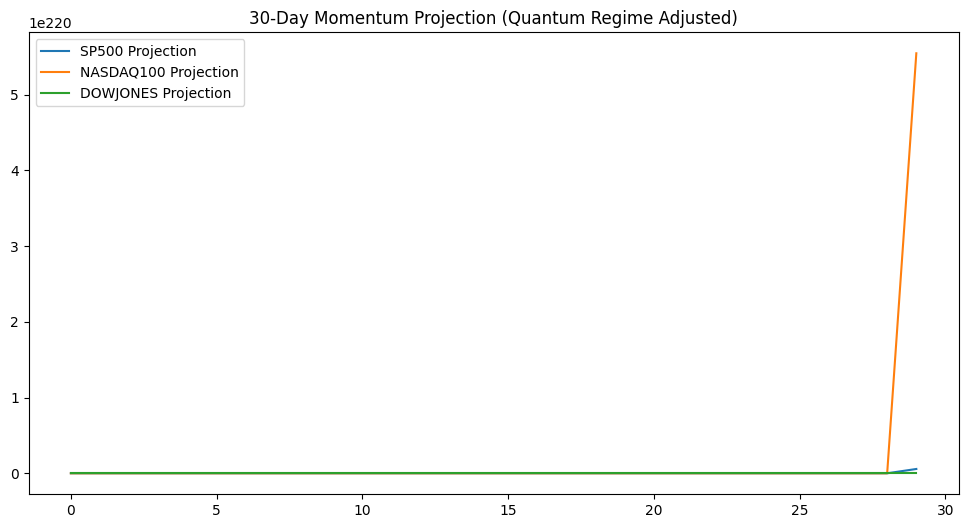

In [ ]:
# ============================================================
# Hybrid Classical + Quantum Momentum Projection Engine
# Lauro Beck - IBM Qiskit Enhanced Model
# ============================================================

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector

# ------------------------------------------------------------
# 1. Download Market Data  (UNCHANGED)
# ------------------------------------------------------------

tickers = {
    "SP500": "^GSPC",
    "NASDAQ100": "^NDX",
    "DOWJONES": "^DJI"
}

data = yf.download(list(tickers.values()), period="2y")["Close"]
data.columns = tickers.keys()

big_tech = yf.download(["AAPL", "MSFT", "NVDA", "GOOGL", "AMZN", "META"],
                       period="2y")["Close"]

big_tech_index = big_tech.mean(axis=1)

# ------------------------------------------------------------
# 2. Log Returns  (UNCHANGED)
# ------------------------------------------------------------

returns = np.log(data / data.shift(1))
bigtech_returns = np.log(big_tech_index / big_tech_index.shift(1))

# ------------------------------------------------------------
# 3. Momentum Signals  (UNCHANGED)
# ------------------------------------------------------------

def momentum_signal(series, short=20, mid=50, long=200):
    mom_short = series.pct_change(short)
    mom_mid = series.pct_change(mid)
    mom_long = series.pct_change(long)

    return (mom_short + mom_mid + mom_long) / 3

momentum = data.apply(momentum_signal)

# ------------------------------------------------------------
# 4. Volatility Adjustment  (UNCHANGED)
# ------------------------------------------------------------

volatility = returns.rolling(30).std()
vol_adj_momentum = momentum / volatility

# ------------------------------------------------------------
# 5. Big Tech Influence  (UNCHANGED)
# ------------------------------------------------------------

bigtech_weight = 0.35
tech_factor = bigtech_returns.rolling(30).mean()

combined_signal = vol_adj_momentum.copy()

for col in combined_signal.columns:
    if col == "NASDAQ100":
        combined_signal[col] += bigtech_weight * tech_factor
    elif col == "SP500":
        combined_signal[col] += bigtech_weight * 0.6 * tech_factor
    elif col == "DOWJONES":
        combined_signal[col] += bigtech_weight * 0.3 * tech_factor

# ------------------------------------------------------------
# 🧠 6. QUANTUM REGIME ENGINE (NEW)
# ------------------------------------------------------------

latest_momentum = combined_signal.iloc[-1]
latest_vol = volatility.iloc[-1]

def normalize(x):
    return (x - x.min()) / (x.max() - x.min() + 1e-9)

mom_norm = normalize(latest_momentum)
vol_norm = normalize(latest_vol)

qc = QuantumCircuit(3)

# Encode momentum → rotations
for i, idx in enumerate(latest_momentum.index):
    qc.ry(float(mom_norm[idx]) * np.pi, i)

# Encode volatility → uncertainty phase
for i, idx in enumerate(latest_vol.index):
    qc.rz(float(vol_norm[idx]) * np.pi, i)

# Big Tech structural dominance → entanglement
qc.cx(1, 0)  # Nasdaq influence
qc.cx(1, 2)

state = Statevector.from_instruction(qc)
probs = state.probabilities()

bullish_prob = probs[7] + probs[6]
bearish_prob = probs[0] + probs[1]
neutral_prob = 1 - bullish_prob - bearish_prob

print("\n=== Quantum Regime Bias ===")
print(f"Bullish: {bullish_prob:.3f}")
print(f"Neutral: {neutral_prob:.3f}")
print(f"Bearish: {bearish_prob:.3f}")

# ------------------------------------------------------------
# 7. Forward Projection (Quantum-Weighted Drift)
# ------------------------------------------------------------

projection_days = 30
last_prices = data.iloc[-1]

drift = combined_signal.iloc[-1]
vol = volatility.iloc[-1]

# Quantum bias adjustment
bias = (bullish_prob - bearish_prob)

projections = {}

for index in data.columns:
    mu = drift[index] * (1 + bias)
    sigma = vol[index]

    simulated = last_prices[index] * np.exp(
        np.cumsum(
            np.random.normal(mu, sigma, projection_days)
        )
    )

    projections[index] = simulated

# ------------------------------------------------------------
# 8. Plot
# ------------------------------------------------------------

plt.figure(figsize=(12,6))

for index in projections:
    plt.plot(projections[index], label=f"{index} Projection")

plt.title("30-Day Momentum Projection (Quantum Regime Adjusted)")
plt.legend()
plt.show()

/tmp/ipython-input-1370745541.py:26: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(list(indices.values()), period="2y")["Close"]
[*********************100%***********************]  3 of 3 completed
/tmp/ipython-input-1370745541.py:29: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bigtech = yf.download(
[*********************100%***********************]  6 of 6 completed


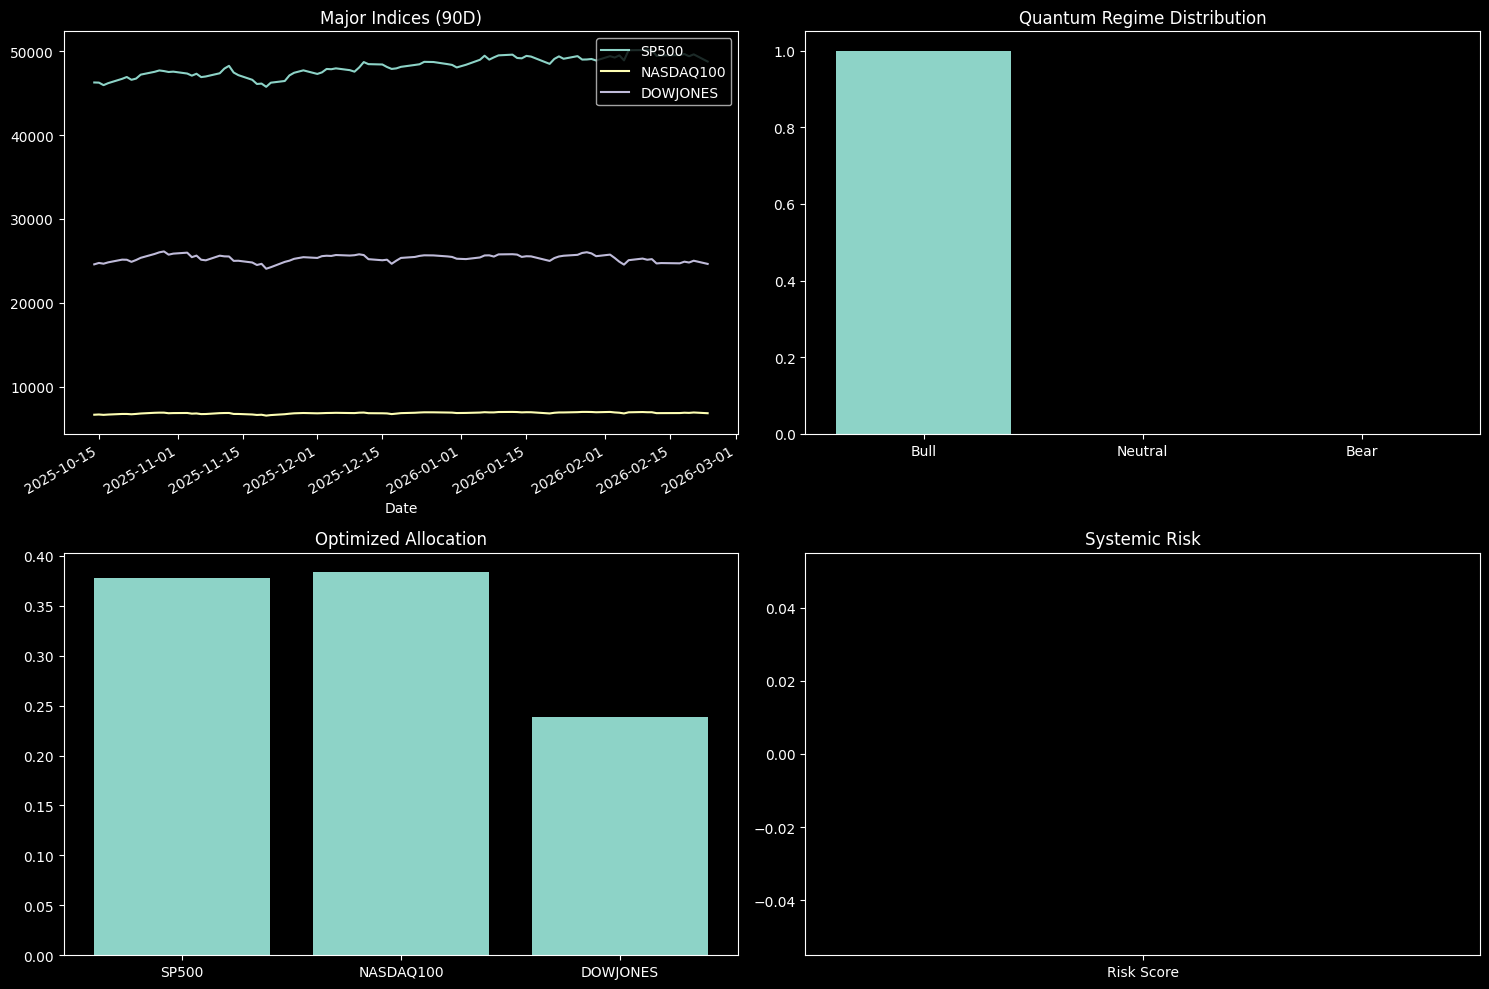


 QUANTUM MACRO DESK SUMMARY

Macro Regime: RISK-ON
Bull Prob: 1.000
Bear Prob: 0.000

Trading Signals:
SP500 : BUY
NASDAQ100 : BUY
DOWJONES : BUY

Portfolio Weights:
SP500        0.377
NASDAQ100    0.384
DOWJONES     0.239
Name: 2026-02-23 00:00:00, dtype: float64

Systemic Risk Score: 0.0000


In [ ]:
# ============================================================
# Quantum Macro Trading Desk
# Lauro Beck - Institutional Hybrid Model
# ============================================================

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector

plt.style.use("dark_background")

# ------------------------------------------------------------
# 1. DATA
# ------------------------------------------------------------

indices = {
    "SP500": "^GSPC",
    "NASDAQ100": "^NDX",
    "DOWJONES": "^DJI"
}

data = yf.download(list(indices.values()), period="2y")["Close"]
data.columns = indices.keys()

bigtech = yf.download(
    ["AAPL","MSFT","NVDA","AMZN","META","GOOGL"],
    period="2y"
)["Close"]

bigtech_index = bigtech.mean(axis=1)

returns = np.log(data / data.shift(1))
bigtech_ret = np.log(bigtech_index / bigtech_index.shift(1))

# ------------------------------------------------------------
# 2. MOMENTUM + VOLATILITY
# ------------------------------------------------------------

def momentum(series):
    return (
        series.pct_change(20) +
        series.pct_change(50) +
        series.pct_change(200)
    ) / 3

mom = data.apply(momentum)
vol = returns.rolling(30).std()

signal = mom / vol

tech_factor = bigtech_ret.rolling(30).mean()

signal["NASDAQ100"] += 0.35 * tech_factor
signal["SP500"] += 0.20 * tech_factor
signal["DOWJONES"] += 0.10 * tech_factor

latest_signal = signal.iloc[-1]
latest_vol = vol.iloc[-1]

# ------------------------------------------------------------
# 3. QUANTUM REGIME ENGINE
# ------------------------------------------------------------

def normalize(x):
    return (x - x.min()) / (x.max() - x.min() + 1e-9)

mom_norm = normalize(latest_signal)
vol_norm = normalize(latest_vol)

qc = QuantumCircuit(3)

for i, col in enumerate(latest_signal.index):
    qc.ry(float(mom_norm[col]) * np.pi, i)
    qc.rz(float(vol_norm[col]) * np.pi, i)

# Entanglement (Nasdaq dominance)
qc.cx(1,0)
qc.cx(1,2)

state = Statevector.from_instruction(qc)
probs = state.probabilities()

bull = probs[7] + probs[6]
bear = probs[0] + probs[1]
neutral = 1 - bull - bear

regime_bias = bull - bear

# ------------------------------------------------------------
# 4. TRADING SIGNALS
# ------------------------------------------------------------

signals = {}

for idx in latest_signal.index:
    adj = latest_signal[idx] * (1 + regime_bias)

    if adj > 0.5:
        signals[idx] = "BUY"
    elif adj < -0.5:
        signals[idx] = "SELL"
    else:
        signals[idx] = "HOLD"

# ------------------------------------------------------------
# 5. RISK DASHBOARD
# ------------------------------------------------------------

risk_score = latest_vol.mean() * (1 - bull)

# ------------------------------------------------------------
# 6. MACRO DETECTOR
# ------------------------------------------------------------

if bull > 0.6:
    macro_regime = "RISK-ON"
elif bear > 0.6:
    macro_regime = "RISK-OFF"
else:
    macro_regime = "TRANSITION"

# ------------------------------------------------------------
# 7. PORTFOLIO OPTIMIZER
# ------------------------------------------------------------

raw_weights = np.maximum(latest_signal * (1 + regime_bias), 0)
weights = raw_weights / raw_weights.sum()

# ------------------------------------------------------------
# 8. BLOOMBERG-STYLE VISUALIZATION
# ------------------------------------------------------------

fig = plt.figure(figsize=(15,10))

# Price
ax1 = plt.subplot(221)
data.iloc[-90:].plot(ax=ax1)
ax1.set_title("Major Indices (90D)")

# Quantum Regime
ax2 = plt.subplot(222)
ax2.bar(["Bull","Neutral","Bear"], [bull,neutral,bear])
ax2.set_title("Quantum Regime Distribution")

# Portfolio Weights
ax3 = plt.subplot(223)
ax3.bar(weights.index, weights.values)
ax3.set_title("Optimized Allocation")

# Risk Meter
ax4 = plt.subplot(224)
ax4.bar(["Risk Score"], [risk_score])
ax4.set_title("Systemic Risk")

plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# PRINT SUMMARY
# ------------------------------------------------------------

print("\n==============================")
print(" QUANTUM MACRO DESK SUMMARY")
print("==============================")

print(f"\nMacro Regime: {macro_regime}")
print(f"Bull Prob: {bull:.3f}")
print(f"Bear Prob: {bear:.3f}")

print("\nTrading Signals:")
for k,v in signals.items():
    print(k, ":", v)

print("\nPortfolio Weights:")
print(weights.round(3))

print(f"\nSystemic Risk Score: {risk_score:.4f}")